
Here we would like to perform some analysis with the U19 pipeline.

First thing first, let's **import the U19 pipeline schemas as virtual module**, and a few other useful packages.

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
lab = dj.create_virtual_module('lab', 'u19_lab') # the first argument here is the __name__ of the virtual module
task = dj.create_virtual_module('task', 'u19_task') 
subject = dj.create_virtual_module('subject', 'u19_subject')
action = dj.create_virtual_module('action', 'u19_action')
acquisition = dj.create_virtual_module('acquisition', 'u19_acquisition')
behavior = dj.create_virtual_module('behavior', 'u19_behavior')

Connecting shans@datajoint00.pni.princeton.edu:3306


## Analyzing existing data

**A simple example: compute the average performance across different blocks within a session**


Let's take a look at the schema behavior

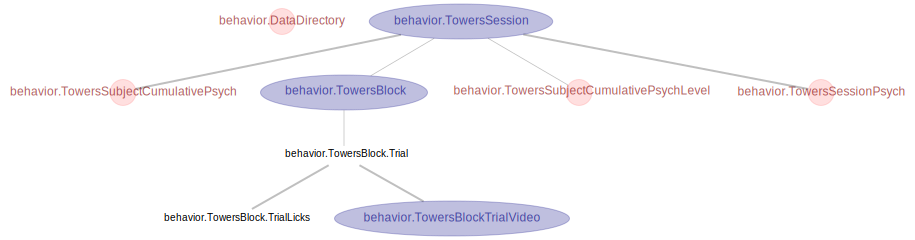

In [2]:
dj.Diagram(behavior)

Take a look at the table `behavior.TowersBlock`

In [3]:
behavior.TowersBlock() # bracket necessary

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,block block number,task,level difficulty level,set_id parameter set id,n_trials number of trials in this block,first_trial trial_idx of the first trial in this block,"block_duration in secs, duration of the block",block_start_time absolute start time of the block,"reward_mil in mL, reward volume in this block",reward_scale scale of the reward in this block,easy_block true if the difficulty reduces during the session,block_performance performance in the current block
ariordan_528,2020-11-12,0,1,Towers,4,1,1,1,26.5905,2020-11-12 16:22:00,0.004,1,0,1.0
ariordan_528,2020-11-12,0,2,Towers,10,1,1,2,46.8463,2020-11-12 16:22:00,0.0,1,0,0.0
ariordan_528,2020-11-12,0,3,Towers,10,1,1,3,51.4178,2020-11-12 16:24:00,0.0,1,0,0.0
ariordan_528,2020-11-13,0,1,Towers,4,1,1,1,13.4724,2020-11-13 14:15:00,0.004,1,0,1.0
ariordan_528,2020-11-13,0,2,Towers,10,1,1,2,40.6044,2020-11-13 14:15:00,0.0,1,0,0.0
ariordan_528,2020-11-16,0,1,Towers,5,1,16,1,464.551,2020-11-16 07:15:00,0.052,1,0,0.8125
ariordan_528,2020-11-16,0,2,Towers,7,1,40,17,1181.22,2020-11-16 07:23:00,0.0672,1,0,0.35
ariordan_528,2020-11-16,0,3,Towers,5,1,10,57,114.071,2020-11-16 07:43:00,0.048,1,1,1.0
ariordan_528,2020-11-16,0,4,Towers,7,1,40,67,900.469,2020-11-16 07:44:00,0.1632,1,0,0.575
ariordan_528,2020-11-16,0,5,Towers,5,1,10,107,131.93,2020-11-16 07:59:00,0.072,2,1,1.0


There is a field called block_performance, of course we could do this in one line:

In [4]:
behavior.TowersSession.aggr(behavior.TowersBlock.proj('block_performance'), 
                            avg_performance='avg(block_performance)')

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,avg_performance calculated attribute
ariordan_528,2020-11-12,0,0.3333333333333333
ariordan_528,2020-11-13,0,0.5
ariordan_528,2020-11-16,0,0.7448129228183201
ariordan_528,2020-12-03,0,0.3333333333333333
ariordan_528,2020-12-04,0,0.0
ariordan_528,2021-01-20,0,0.0
efonseca_EF002,2020-02-25,0,0.604651153087616
efonseca_EF002,2020-02-26,0,0.800000011920929
efonseca_EF002,2020-02-27,0,0.4166666716337204
efonseca_EF002,2020-02-28,0,0.30000001192092896


But now let's do it with a computed table, for fun :)

## Create your own schema and tables

The first thing we would like to do is to create a schema with `dj.schema`.  
**Note**: the schema name you create has to either start with your username, which is only accessible by you, Here we use our user_name  

In [5]:
schema = dj.schema('shans_tutorial')

Let's check if the new schema is there:

In [6]:
dj.list_schemas()

['U19_subject',
 'aarusso_pipeline',
 'aarusso_puffs',
 'aarusso_puffs_py',
 'aarusso_tutorial',
 'abondy_tutorial',
 'ahoag_admin_demo',
 'ahoag_admin_flask_demo',
 'ahoag_celery_test',
 'ahoag_lab_test',
 'ahoag_lightsheet_demo',
 'ahoag_microscope_demo',
 'ahoag_microscope_demo_old',
 'ahoag_puffs_acquisition_demo',
 'ahoag_puffs_behavior_demo',
 'ahoag_puffs_lab_demo',
 'ahoag_spockadmin_demo',
 'ahoag_test_db',
 'ahoag_tutorial',
 'brody_2pdemo',
 'brody_trash',
 'brody_tutorial2',
 'brody_tutorial3',
 'brody_tutorial5',
 'ckopec_tutorial_db',
 'diamanti_tutorial',
 'dikshag_pipeline',
 'dikshag_tutorial',
 'gtm_testdb',
 'jounhong_session1',
 'jounhong_tutorial',
 'jyanar_tutorial3',
 'lpinto_tutorial',
 'ms81_tutorial',
 'mysql',
 'performance_schema',
 'sf11_DTSC',
 'shans_acquisition',
 'shans_action',
 'shans_behavior',
 'shans_imaging',
 'shans_lab',
 'shans_reference',
 'shans_subject',
 'shans_task',
 'shans_tutorial',
 'shans_tutorial2',
 'tdkim_tutorial',
 'test',
 'u19_

Now let's define a **Manual** table to save the result.  
A class created with DataJoint correponds to a table in the database.

In [7]:
@schema
class SessionPerformanceManual(dj.Manual):
    definition = """
    -> behavior.TowersSession         # each session have an average performance
    ---
    avg_performance:      float   # a final product in this table
    """

Let's take a look at the brand-new table we just created.

In [8]:
SessionPerformanceManual()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,avg_performance a final product in this table


Yes, sure, it's empty. We haven't inserted anything into it.  
Now let's insert the firing rate we just computed into this empty table.  
We need to insert the entry with all fields defined in the table, usually in a format of dictionary.

Let's first compute the performance for one session, let's pick a session:

In [9]:
behavior.TowersSession.aggr(behavior.TowersBlock.proj(),
                            n_sessions='count(*)')

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,n_sessions calculated attribute
ariordan_528,2020-11-12,0,3
ariordan_528,2020-11-13,0,2
ariordan_528,2020-11-16,0,7
ariordan_528,2020-12-03,0,3
ariordan_528,2020-12-04,0,2
ariordan_528,2021-01-20,0,1
efonseca_EF002,2020-02-25,0,1
efonseca_EF002,2020-02-26,0,1
efonseca_EF002,2020-02-27,0,2
efonseca_EF002,2020-02-28,0,1


This session has 7 blocks:

In [10]:
key = {
    'subject_fullname': 'emanuele_B205',
    'session_date': datetime.date(2018, 7, 13),
    'session_number': 0
}

In [11]:
behavior.TowersBlock & key

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,block block number,task,level difficulty level,set_id parameter set id,n_trials number of trials in this block,first_trial trial_idx of the first trial in this block,"block_duration in secs, duration of the block",block_start_time absolute start time of the block,"reward_mil in mL, reward volume in this block",reward_scale scale of the reward in this block,easy_block true if the difficulty reduces during the session,block_performance performance in the current block
emanuele_B205,2018-07-13,0,1,Towers,4,1,10,1,103.129,2018-07-13 10:57:00,0.04,1,0,1.0
emanuele_B205,2018-07-13,0,2,Towers,9,1,91,11,1208.35,2018-07-13 10:59:00,0.4688,1,0,0.692308
emanuele_B205,2018-07-13,0,3,Towers,7,1,10,102,139.089,2018-07-13 11:19:00,0.056,2,1,0.7
emanuele_B205,2018-07-13,0,4,Towers,9,1,41,112,617.258,2018-07-13 11:21:00,0.248,2,0,0.585366
emanuele_B205,2018-07-13,0,5,Towers,7,1,10,153,152.102,2018-07-13 11:31:00,0.072,3,1,0.6
emanuele_B205,2018-07-13,0,6,Towers,9,1,47,163,764.342,2018-07-13 11:34:00,0.336,3,0,0.595745
emanuele_B205,2018-07-13,0,7,Towers,7,1,9,210,153.767,2018-07-13 11:47:00,0.072,3,1,0.666667


In [12]:
performances = (behavior.TowersBlock & key).fetch('block_performance')

# create another field in the dictionary key
key['avg_performance'] = np.mean(performances)

In [13]:
key

{'subject_fullname': 'emanuele_B205',
 'session_date': datetime.date(2018, 7, 13),
 'session_number': 0,
 'avg_performance': 0.6914408571428572}

Now insert it!

In [14]:
SessionPerformanceManual.insert1(key, skip_duplicates=True) # insert1 only works for one entry

Let's check the table again to see what happened:

In [15]:
SessionPerformanceManual()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,avg_performance a final product in this table
emanuele_B205,2018-07-13,0,0.691441


Cool the entry is there!

So we can of course write a for loop to compute all avg performance and insert them one by one, but that's too slow. We can compute the results and insert them all at once! Now let's compare the two senarios.
1. insert one by one
2. insert all together

Let's pick two animals that have the same number of sessions.

In [19]:
subject.Subject.aggr(behavior.TowersSession.proj(), n_sessions='count(*)') & 'n_sessions=100'

subject_fullname username_mouse_nickname,n_sessions calculated attribute
hnieh_E57,100
hnieh_E77,100


Subjects E78 and vg28 happen to have the same number of sessions.

In [20]:
# loop through sessions of subject B205 and insert one by one, and compute time
import time
start_time = time.time()

for i_session in (behavior.TowersSession & 'subject_fullname="hnieh_E57"').fetch('KEY'):
    performances = (behavior.TowersBlock & i_session).fetch('block_performance')
    # create another field in the dictionary key
    avg_performance = np.mean(performances)
    if np.isnan(avg_performance):
        continue
    entry = dict(**i_session, 
                 avg_performance=avg_performance)
    SessionPerformanceManual.insert1(entry)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.5121302604675293 seconds ---


In [21]:
# loop through sessions of subject B3151 and insert all at once as a list of dictionaries!
start_time = time.time()

perf_entries = []
for i_session in (behavior.TowersSession & 'subject_fullname="hnieh_E77"').fetch('KEY'):
    performances = (behavior.TowersBlock & i_session).fetch('block_performance')
    # create another field in the dictionary key
    avg_performance = np.mean(performances)
    if np.isnan(avg_performance):
        continue
    entry = dict(**i_session, 
                 avg_performance=avg_performance)
    perf_entries.append(entry)
    
SessionPerformanceManual.insert(perf_entries)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.755570650100708 seconds ---


In this way, we will need to remember which clusters has been computed and inserted. If we insert the same entry twice, there will be an error. For example, let's rerun the above cell. We can overcome that problem by add the argument `skip_duplicates=True` inside `.insert()` or `.insert1()`, but it is not a very elegant solution.  
The best approach here is to use a **Computed** table, it has the exact definition as the previous manual table, but with a magic **make** function

In [24]:
@schema
class SessionPerformanceComputed(dj.Computed):
    definition = """
    -> behavior.TowersSession         # each session have an average performance
    ---
    avg_performance:      float   # a final product in this table
    """
    
    key_source = acquisition.Session() & 'subject_fullname="hnieh_E57"' # bracket necessary
    def make(self, key): # key is one primary key of the entries in table acquisition.Session
        # fetch the performance for each block
        performances = (behavior.TowersBlock & key).fetch('block_performance')
        
        # create another field in the dictionary key
        key['avg_performance'] = np.mean(performances)
        self.insert1(key)

And we can `populate` the table.

In [27]:
SessionPerformanceComputed.populate(display_progress=True) 
# first argument could be some restrictor to control the populate

0it [00:00, ?it/s]


In [26]:
SessionPerformanceComputed()

subject_fullname username_mouse_nickname,session_date date of experiment,session_number number,avg_performance a final product in this table
hnieh_E55,2017-08-24,0,0.0
hnieh_E55,2017-08-25,0,0.4
hnieh_E55,2017-08-26,0,0.533333
hnieh_E55,2017-08-29,0,0.657924
hnieh_E55,2017-08-30,0,0.535714
hnieh_E55,2017-08-31,0,0.72371
hnieh_E55,2017-09-01,0,0.900433
hnieh_E55,2017-09-02,0,0.817491
hnieh_E55,2017-09-05,0,0.959184
hnieh_E55,2017-09-06,0,0.821782


**What does `populate` do?** 

It does two major things:  
1. From the table definition, get the keys that needs to computed, which we called `key_source`. By default, it would be the join result of the primary dependent tables minus the once has been computed.  
2. Call `make` function defined in the class, and compute one by one, with each individual key from the `key_source`

Here we still have to insert one by one, which is a bit slow. How do we do the trick of insert all firing rate of clusters in one session together?

We can change the `key_source` by redefining it to a larger scale

In [29]:
@schema
class SessionPerformanceComputedFromSubject(dj.Computed):
    definition = """
    -> behavior.TowersSession         # each session have an average performance
    ---
    avg_performance:      float   # a final product in this table
    """
    key_source = subject.Subject() 
    def make(self, key): # key is one primary key of the entries in table subject.Subject()!

        perf_entries = []
        for i_session in (behavior.TowersSession & key).fetch('KEY'):
            # fetch performance of each block
            performances = (behavior.TowersBlock & i_session).fetch('block_performance')
            # create another field in the dictionary key
            avg_performance = np.mean(performances)
            if np.isnan(avg_performance):
                continue
            entry = dict(**i_session, 
                         avg_performance=avg_performance)
            perf_entries.append(entry)
            
        self.insert(perf_entries)

In [31]:
SessionPerformanceComputedFromSubject.populate('subject_fullname="hnieh_E77"', display_progress=True, suppress_errors=True, reserve_jobs=True)

100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


[]

## Delete entries and drop a table

In [ ]:
(SessionPerformanceManual & 'subject_fullname="hnieh_E78"').delete() # any restrictor would work here

In [ ]:
SessionPerformanceManual.drop()

In [ ]:
SessionPerformanceComputed.drop()

In [ ]:
SessionPerformanceComputedFromSubject.drop()